# -DATA SCIENCE NOTEBOOK- 

This notebook is for the EDA and modeling of the cleaned up data the data engineers came up with in the gold layer. 

Data Source: cscie103_catalog_final.gold.daily_energy_report

Permanantly save the combined file Liwei made in 05B, otherwise it disapears with the pipeline

## EDA

Coverting to pandas for better visualization, dataset is 10208x4

In [0]:
#Load data into spark dataframe 
data = spark.table("cscie103_catalog_final.gold.daily_energy_report")
#data.show(20)
#data.count() #10208 rows
#data.printSchema()

#I don't like the look of this table, convert to pandas
pdf = data.toPandas()
pdf.head()

date  county  total_energy   avg_temp
0  2022-02-05      14     34395.715  -1.558333
1  2022-03-24      10     31881.715   3.562500
2  2022-07-14      11    111755.540  16.589583
3  2022-08-16      10     33387.406  23.758333
4  2022-11-10      13      8408.299   8.816667

Data dimentions, stats and basic metadata

In [0]:
pdf.shape
pdf.info()
pdf.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10208 entries, 0 to 10207
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          10208 non-null  object 
 1   county        10208 non-null  int32  
 2   total_energy  10208 non-null  float64
 3   avg_temp      4459 non-null   float64
dtypes: float64(2), int32(1), object(1)
memory usage: 279.3+ KB


date        county   total_energy     avg_temp
count        10208  10208.000000   10208.000000  4459.000000
unique         638           NaN            NaN          NaN
top     2022-02-05           NaN            NaN          NaN
freq            16           NaN            NaN          NaN
mean           NaN      7.500000   45534.277745     5.366365
std            NaN      4.609998   70676.702824     8.156070
min            NaN      0.000000     424.708000   -20.666667
25%            NaN      3.750000    9964.147750    -0.685417
50%            NaN      7.500000   22226.367000     5.329167
75%            NaN     11.250000   41552.087750    10.729167
max            NaN     15.000000  469581.218000    26.241667

I can already see that there are NaN values, get rid of these. 

In [0]:
pdf.isnull().sum().sort_values(ascending=False)

avg_temp        5749
date               0
county             0
total_energy       0
dtype: int64

There are only nulls in the avg_temp column. More than half of all avg_temp values are null, drop these rows. 

In [0]:
#Drop null rows
cleaned = pdf.dropna().copy()
cleaned.count()

date            4459
county          4459
total_energy    4459
avg_temp        4459
dtype: int64

In [0]:
#check for duplicates
cleaned.duplicated().sum()


np.int64(0)

There are no duplicates

Check for the skewness of data, plot it out. Date is in object type, convert to datetime for the purpose of visualization. 

/home/spark-63657d35-4d97-4d6a-8936-de/.ipykernel/2483/command-7413783606543686-300353529:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['date'] = pd.to_datetime(cleaned['date'], errors='coerce')


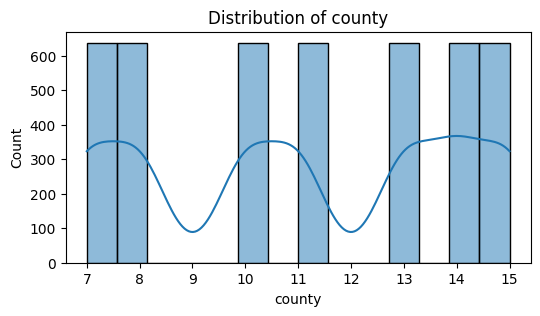

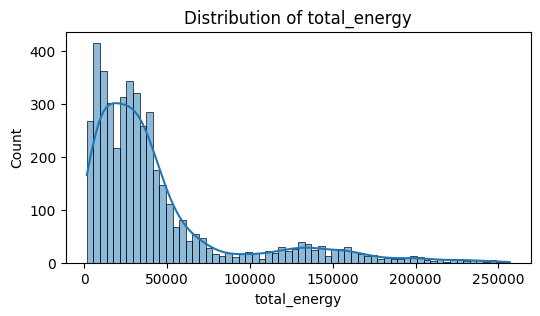

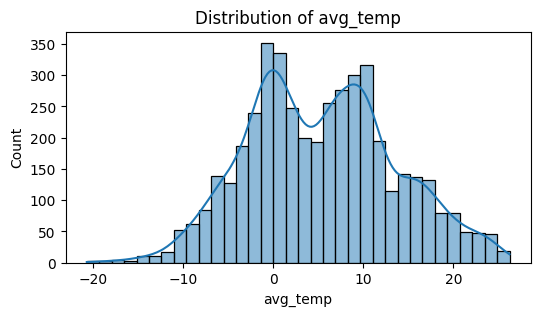

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#fix format of date
cleaned['date'] = pd.to_datetime(cleaned['date'], errors='coerce')

num_cols = cleaned.select_dtypes(include=['float64', 'int64', 'int32']).columns
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(cleaned[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

Visualize the date time differently. This plots total energy over time.

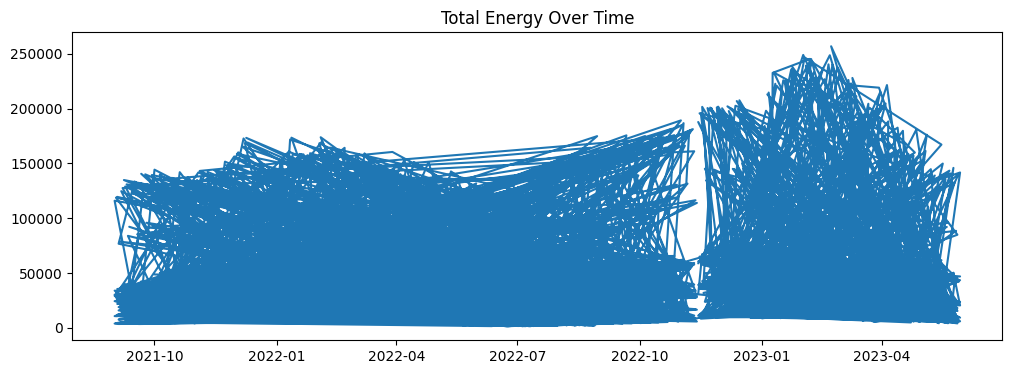

In [0]:
plt.figure(figsize=(12,4))
plt.plot(cleaned['date'],cleaned['total_energy'])
plt.title("Total Energy Over Time")
plt.show()

Look at the relationship between total_eergy with county vs avg_temp


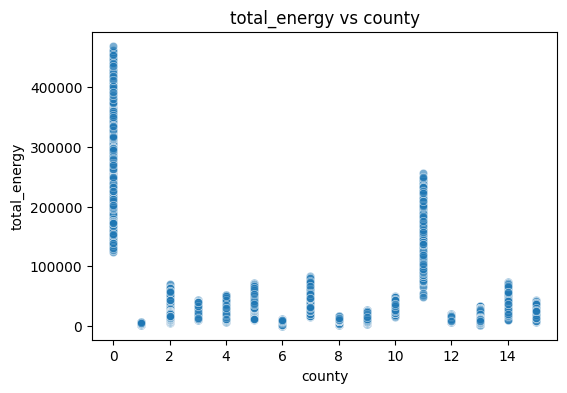

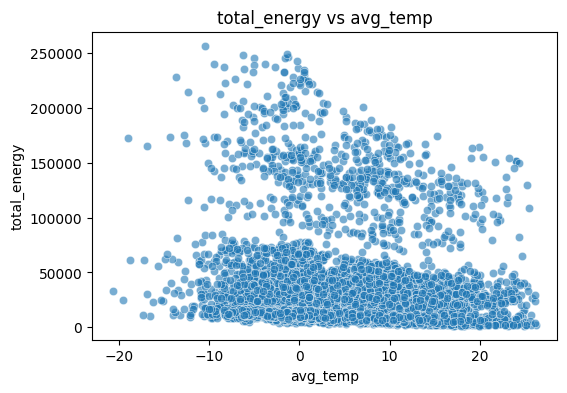

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = cleaned.select_dtypes(include='number').columns
num_cols = num_cols.drop('total_energy', errors='ignore')

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=pdf, x=col, y='total_energy', alpha=0.6)
    plt.title(f"total_energy vs {col}")
    plt.xlabel(col)
    plt.ylabel("total_energy")
    plt.show()

Boxplots for all the outliers in data 

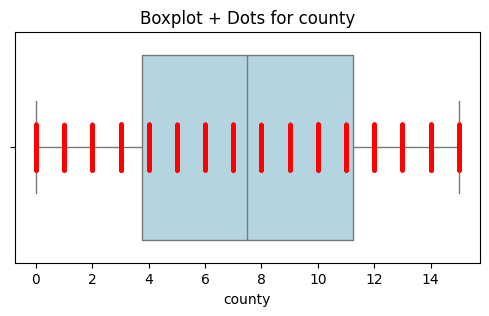

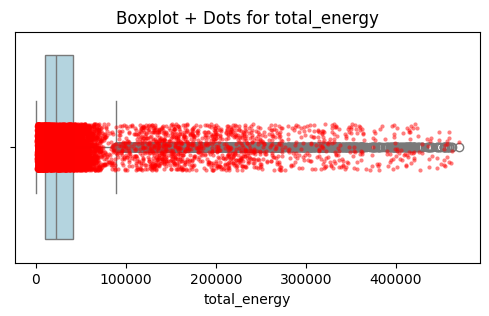

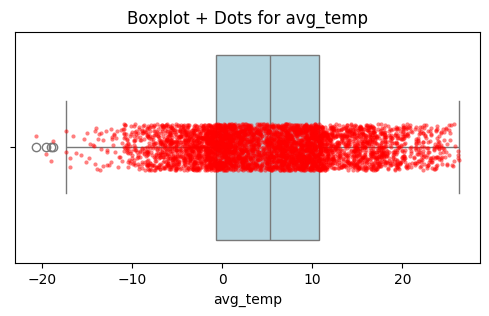

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = cleaned.select_dtypes(include=['float64', 'int64', 'int32']).columns

for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=pdf[col], color="lightblue")
    sns.stripplot(x=pdf[col], color="red", size=3, alpha=0.5)  # dots for all values
    plt.title(f"Boxplot + Dots for {col}")
    plt.show()

In [0]:
Total energy has the most outliers. Avg_temp only have a few. 

Make a correlation matrix

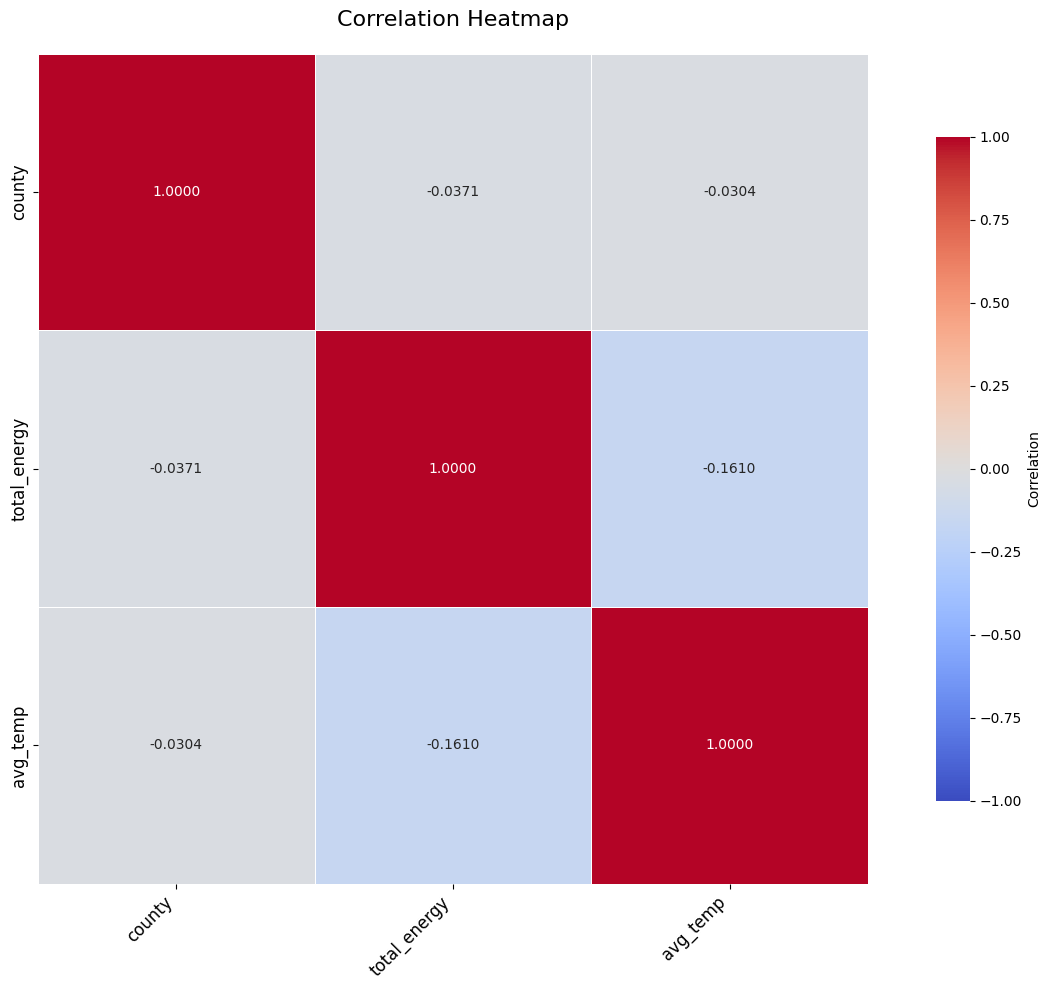

In [0]:
#correlation matrix 
plt.figure(figsize=(14,10))
corr = cleaned[num_cols].corr()

sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,            
    fmt=".4f",             
    vmin=-1, vmax=1,   
    center=0,              # center colormap at 0
    square=True,           
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)

plt.title("Correlation Heatmap", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

The highest correlation is 0.16. No strong reason to drop any of the variables for the ML model. 

Check for seasonability patterns for the datetime data. There is no hour, so we can only look at seasonality, it would be interesting to look for the daily patterns if they had regular daily measurements. 

/home/spark-63657d35-4d97-4d6a-8936-de/.ipykernel/2483/command-7413783606543698-4059018704:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['month'] = cleaned['date'].dt.month
/home/spark-63657d35-4d97-4d6a-8936-de/.ipykernel/2483/command-7413783606543698-4059018704:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['hour'] = cleaned['date'].dt.hour


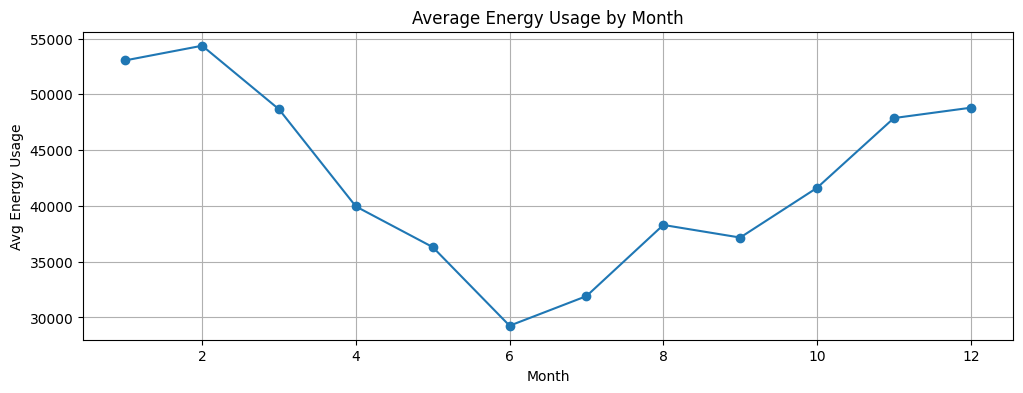

In [0]:

cleaned['month'] = cleaned['date'].dt.month
cleaned['hour'] = cleaned['date'].dt.hour

plt.figure(figsize=(12,4))
cleaned.groupby('month')['total_energy'].mean().plot(marker='o')
plt.title("Average Energy Usage by Month")
plt.xlabel("Month")
plt.ylabel("Avg Energy Usage")
plt.grid(True)
plt.show()


The most energy is used in the winter/cold months. 

Focusing more on the target variable: total_energy

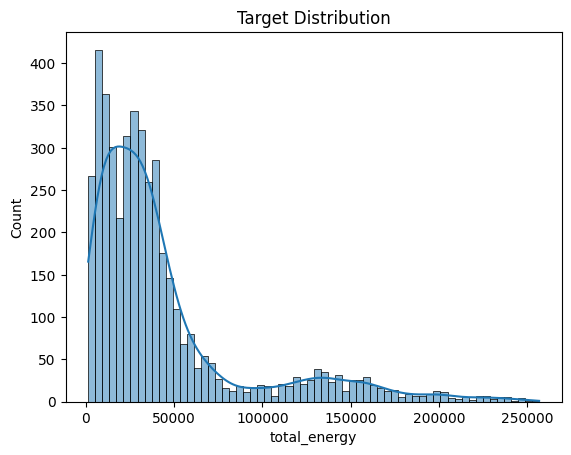

In [0]:
sns.histplot(cleaned['total_energy'], kde=True)
plt.title("Target Distribution")
plt.show()

In [0]:
#Quantify skew
cleaned['total_energy'].skew()

np.float64(2.0338635380888945)

Target variable is very skewed >1, need to log transform the data for ML

In [0]:
cleaned = cleaned.copy()
cleaned.loc[:, 'total_energy_log'] = np.log1p(cleaned['total_energy'])

#show dataset
cleaned.head()

date  county  total_energy   avg_temp  total_energy_log
0  2022-02-05      14     34395.715  -1.558333         10.445716
1  2022-03-24      10     31881.715   3.562500         10.369819
2  2022-07-14      11    111755.540  16.589583         11.624078
3  2022-08-16      10     33387.406  23.758333         10.415964
4  2022-11-10      13      8408.299   8.816667          9.037093

look for feature-target relationship

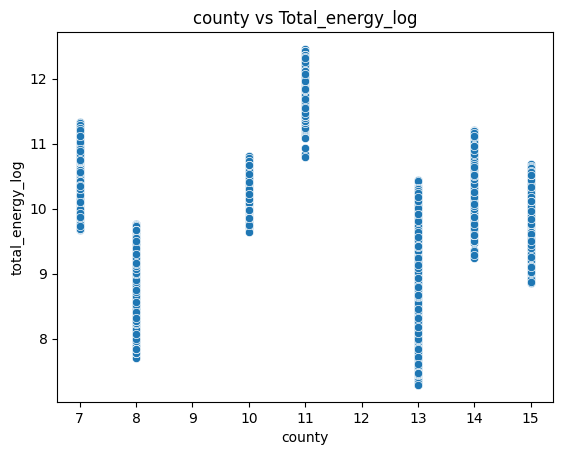

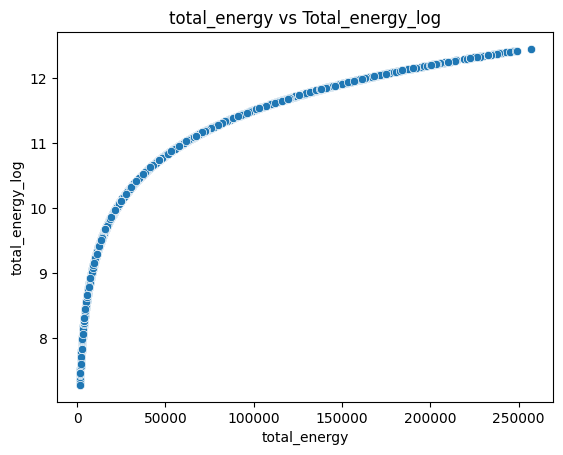

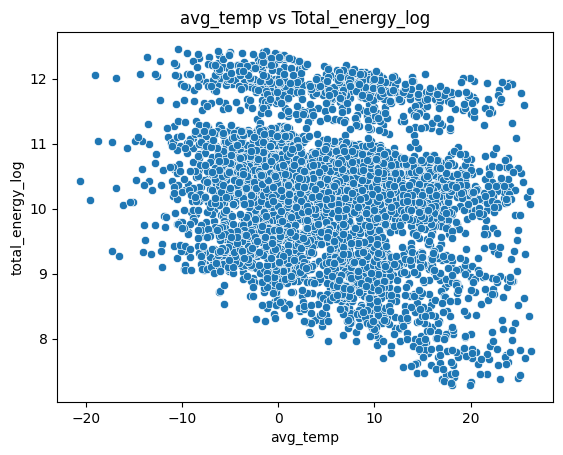

In [0]:
for col in num_cols:
    if col != 'total_energy_log':
        sns.scatterplot(data=cleaned, x=col, y='total_energy_log')
        plt.title(f"{col} vs Total_energy_log")
        plt.show()

# Building the model

In [0]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import mlflow
import mlflow.spark

In [0]:
# Load the gold table
data = spark.table("cscie103_catalog_final.gold.daily_energy_report")

data.printSchema()
data.show(5)

root
 |-- date: date (nullable = true)
 |-- county: integer (nullable = true)
 |-- total_energy: double (nullable = true)
 |-- avg_temp: double (nullable = true)

+----------+------+------------------+------------------+
|      date|county|      total_energy|          avg_temp|
+----------+------+------------------+------------------+
|2022-02-05|    14|34395.715000000004|-1.558333333333333|
|2022-03-24|    10|31881.714999999997|            3.5625|
|2022-07-14|    11|111755.54000000005|16.589583333333334|
|2022-08-16|    10|33387.405999999995|23.758333333333336|
|2022-11-10|    13| 8408.298999999997| 8.816666666666666|
+----------+------+------------------+------------------+
only showing top 5 rows


Repeating some of the steps from before. pandas were good for EDA and visualizing. Now focusing on using spark for modeling. Average_temp is missing a lot of rows, and dropping them all makes me lose too mcuh data, so I am imputing those NaN values with the average instead. 

In [0]:
#Date time needs to be fixed again 
data = data.withColumn("date", F.to_date("date"))

# Basic date features
data = (
    data
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .withColumn("dayofweek", F.dayofweek("date"))
)

# Impute avg_temp with mean
avg_temp_mean = data.select(F.mean("avg_temp")).first()[0]
data = data.fillna({"avg_temp": avg_temp_mean})

# Drop rows if there are still nulls
data = data.filter(F.col("total_energy").isNotNull())

In [0]:
data.printSchema()


root
 |-- date: date (nullable = true)
 |-- county: integer (nullable = true)
 |-- total_energy: double (nullable = true)
 |-- avg_temp: double (nullable = false)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)



Don't forget to convert total_energy to log_total_energy for your model


In [0]:
from pyspark.sql.functions import log1p, col

data = data.withColumn("log_total_energy", log1p(col("total_energy")))

data.printSchema()


root
 |-- date: date (nullable = true)
 |-- county: integer (nullable = true)
 |-- total_energy: double (nullable = true)
 |-- avg_temp: double (nullable = false)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- log_total_energy: double (nullable = true)



Split data into train and test 

In [0]:
trainDF, testDF = data.randomSplit([0.8, 0.2], seed=12)
print(trainDF.count(), testDF.count())

8160 2048


Initially wanted to use autoML, however the free edition databricks environment does not support it, so I need to train the model myself, Spark → Pandas → scikit-learn . 

In [0]:
#Confirm training data size and contents
trainDF.printSchema()
trainDF.count()

root
 |-- date: date (nullable = true)
 |-- county: integer (nullable = true)
 |-- total_energy: double (nullable = true)
 |-- avg_temp: double (nullable = false)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- log_total_energy: double (nullable = true)



8160

Using xgboost instead. Need to pip install

In [0]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 16.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
FEATURES = ["avg_temp", "county", "year", "month", "dayofweek"]
LABEL = "log_total_energy"

train_pd = trainDF.select(FEATURES + [LABEL]).dropna().toPandas()
test_pd  = testDF.select(FEATURES + [LABEL]).dropna().toPandas()

In [0]:
X_train = train_pd[FEATURES]      # ← training FEATURES
y_train = train_pd[LABEL]         # ← training LABEL

X_test  = test_pd[FEATURES]       # ← testing FEATURES
y_test  = test_pd[LABEL]          # ← testing LABEL

In [0]:
import mlflow
import mlflow.xgboost
import numpy as np
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mlflow.set_experiment("/Workspace/Users/seo549@g.harvard.edu/energy_xgboost")

mlflow.xgboost.autolog(log_models=True)

with mlflow.start_run(run_name="xgb_regressor"):
    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
# this is what actually trains the model
    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae  = mean_absolute_error(y_test, pred)
    r2   = r2_score(y_test, pred)

    mlflow.log_metric("rmse_log_test", rmse)
    mlflow.log_metric("mae_log_test", mae)
    mlflow.log_metric("r2_log_test", r2)

    print({"rmse_log_test": rmse, "mae_log_test": mae, "r2_log_test": r2})

    run_id = mlflow.active_run().info.run_id
    model_uri = f"runs:/{run_id}/model"

2025/12/12 17:08:15 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.1.2. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/12/12 17:08:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing v

{'rmse_log_test': np.float64(0.15547874416165672), 'mae_log_test': 0.10911080468189888, 'r2_log_test': 0.9831858917792271}


In [0]:
out_pd = test_pd.copy()
out_pd["pred_log_total_energy"] = pred

# correct inverse for log1p
out_pd["pred_total_energy"] = np.expm1(out_pd["pred_log_total_energy"])
out_pd["actual_total_energy"] = np.expm1(out_pd[LABEL])

out_pd["abs_err"] = np.abs(out_pd["pred_total_energy"] - out_pd["actual_total_energy"])
out_pd["pct_err"] = out_pd["abs_err"] / out_pd["actual_total_energy"]

spark.createDataFrame(out_pd).write \
    .mode("overwrite") \
    .format("delta") \
    .saveAsTable("gold_daily_energy_predictions")

In [0]:
#Table to show actua and prediction values 

display(spark.table("gold_daily_energy_predictions"))



avg_temp county year month dayofweek log_total_energy pred_log_total_energy pred_total_energy actual_total_energy abs_err pct_err 5.366365360829643 2 2022 7 7 8.963064975811978 9.061553 8616.523 7808.255999999999 808.2674375000006 0.10351446436950847 5.366365360829643 3 2022 7 1 9.680506862959225 9.467964 12937.52 16001.605999999994 3064.0864687499943 0.19148618387116864 5.366365360829643 4 2022 7 1 9.50030857922928 9.52532 13701.314 13362.850000000006 338.4644531249942 0.025328762436530684 13.758333333333333 7 2022 7 1 9.82942870994476 9.936075 20661.488 18571.34100000001 2090.1472812499887 0.11254692276933516 14.124999999999998 8 2022 7 1 8.68535784378612 8.542401 5126.6426 5914.656999999994 788.0144218749938 0.1332307895242268 5.366365360829643 4 2022 7 2 10.04275959231991 10.015872 22377.86 22987.735 609.8756250000006 0.026530479188141005 14.995833333333335 8 2022 7 2 8.895100583107777 8.806048 6673.492 7295.138999999997 621.6468124999974 0.08521384068213061 14.647916666666669 11 2022 7 2 11.611418691683289 11.62487 111844.12 110349.69300000017 1494.424187499826 0.013542622066921597 5.366365360829643 1 2022 7 3 7.666987908569504 7.752712 2326.8765 2135.636 191.24046484375003 0.08954731276479233 5.366365360829643 3 2022 7 3 9.733747614195012 9.760041 17326.346 16876.685000000016 449.66070312498414 0.02664389974245438 5.366365360829643 12 2022 7 3 9.247677774350963 9.290081 10829.062 10379.431999999993 449.6295234375066 0.04331928023012308 16.022500000000004 15 2022 7 3 10.199463262500007 10.059577 23377.615 26887.749999999985 3510.1347656249854 0.13054773142509088 17.383333333333336 8 2022 7 4 8.791353758956701 8.9705515 7866.9395 6576.13 1290.809453125 0.19628709486050305 16.708333333333332 13 2022 7 4 7.850502530262572 7.8627915 2597.765 2566.0239999999976 31.740892578127387 0.012369678762991857 16.400000000000002 14 2022 7 4 10.55408207517482 10.627459 41251.152 38332.60000000001 2918.552343749987 0.07613760464330585 16.702500000000008 15 2022 7 4 10.005452991437583 9.92984 20533.057 22145.903999999995 1612.847359374995 0.0728282466759991 5.366365360829643 9 2022 7 5 8.474997128295964 8.710724 6066.633 4792.409000000004 1274.2238124999958 0.26588377838786187 5.366365360829643 3 2022 7 6 9.639660994438254 9.7554245 17246.535 15361.135000000002 1885.400156249998 0.12273833647383463 22.164583333333336 7 2022 7 6 10.243341742472294 10.267288 28774.748 28093.85500000003 680.8930468749713 0.024236369372411533 21.816666666666666 10 2022 7 6 10.34375329913138 10.326513 30530.473 31061.39800000002 530.9253437500192 0.017092770381745823 5.366365360829643 5 2022 7 7 9.470037467323674 9.855087 19054.047 12964.373000000003 6089.673874999997 0.4697237479205508 5.366365360829643 9 2022 7 1 8.553196040486041 8.3908825 4405.705 5182.294 776.5889218749999 0.1498542772515415 5.366365360829643 6 2022 7 2 7.894117074218761 7.6609573 2122.7896 2680.4610000000007 557.6714492187507 0.20805057384485376 18.987499999999994 10 2022 7 2 10.240200867238542 10.378343 32154.623 28005.750999999997 4148.872046875003 0.1481435740421674 5.366365360829643 0 2022 7 3 12.291642597499054 12.241514 207214.42 217866.55199999988 10652.13012499988 0.04889291186377193 18.825 10 2022 7 3 10.44548766291371 10.400744 32883.098 34387.85000000001 1504.752343750013 0.043758256004664806 20.5125 13 2022 7 3 7.793173522106357 7.747613 2315.0374 2422.9980000000005 107.9606464843755 0.0445566387113714 19.666666666666664 14 2022 7 3 10.764376794510492 10.707391 44683.895 47304.26099999997 2620.3664687499695 0.05539387812759555 5.366365360829643 0 2022 7 5 12.281755272620961 12.239154 206725.9 215723.03900000005 8997.132750000048 0.04170687002977019 5.366365360829643 2 2022 7 5 9.255430747981347 9.189803 9795.722 10460.223999999993 664.5023203124929 0.06352658607621532 5.366365360829643 3 2022 7 5 9.780589651982178 9.752287 17192.504 17686.07900000001 493.5750937500088 0.027907547724399996 15.4125 7 2022 7 5 10.495912803654663 10.470407 35255.547 36166.376999999986 910.83012499

compute real unit metrics 

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse_energy = np.sqrt(mean_squared_error(out_pd["actual_total_energy"], out_pd["pred_total_energy"]))
mae_energy  = mean_absolute_error(out_pd["actual_total_energy"], out_pd["pred_total_energy"])
r2_energy   = r2_score(out_pd["actual_total_energy"], out_pd["pred_total_energy"])
mape_energy = np.mean(
    np.abs(out_pd["pred_total_energy"] - out_pd["actual_total_energy"])
    / out_pd["actual_total_energy"]
)

print({
    "rmse_energy": rmse_energy,
    "mae_energy": mae_energy,
    "r2_energy": r2_energy,
    "mape_energy": mape_energy
})

{'rmse_energy': np.float64(8288.636690926742), 'mae_energy': 4030.357025509118, 'r2_energy': 0.986583720545137, 'mape_energy': np.float64(0.11111671320015866)}


In [0]:
spark.table("gold_daily_energy_predictions").selectExpr(
  "avg(abs_err) as MAE_energy",
  "sqrt(avg(pow(pred_total_energy - actual_total_energy, 2))) as RMSE_energy",
  "avg(pct_err) as MAPE_energy"
).show()

+------------------+-----------------+-------------------+
|        MAE_energy|      RMSE_energy|        MAPE_energy|
+------------------+-----------------+-------------------+
|4030.3570711066695|8288.636816756938|0.11110437924263175|
+------------------+-----------------+-------------------+



Visualize prection vs measurement 

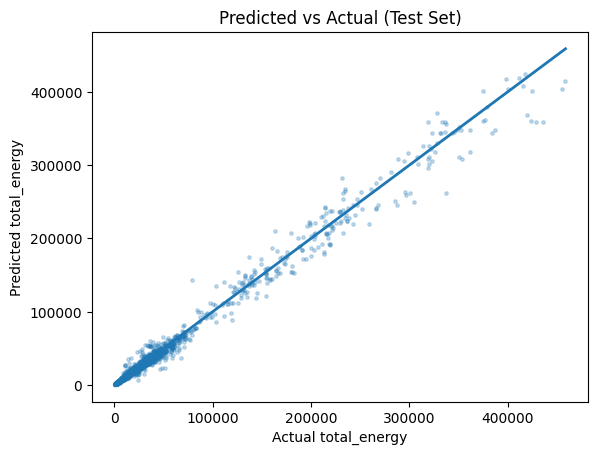

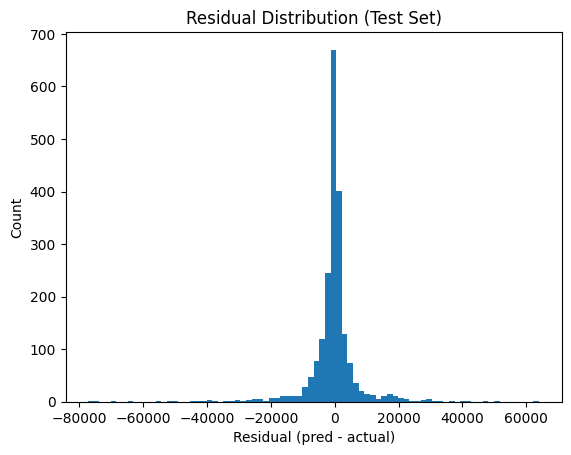

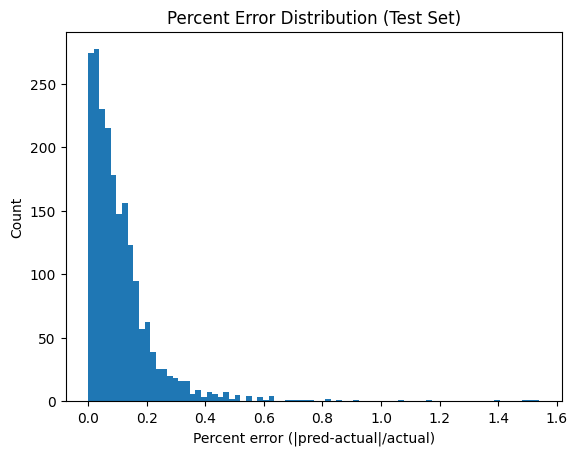

count         mean  ...           99%           max
abs_err  2048.0  4030.357026  ...  37861.513856  77245.772500
pct_err  2048.0     0.111117  ...      0.582239      1.539631

[2 rows x 9 columns]

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load saved predictions table
df = spark.table("gold_daily_energy_predictions")

# Pull a manageable sample to the driver for plotting
# (If it's small, you can drop the limit.)
pdf = (df
       .select("actual_total_energy", "pred_total_energy", "abs_err", "pct_err")
       .dropna()
       .limit(200000)
       .toPandas())

# 1) Predicted vs Actual scatter
plt.figure()
plt.scatter(pdf["actual_total_energy"], pdf["pred_total_energy"], s=6, alpha=0.25)
mn = float(np.nanmin([pdf["actual_total_energy"].min(), pdf["pred_total_energy"].min()]))
mx = float(np.nanmax([pdf["actual_total_energy"].max(), pdf["pred_total_energy"].max()]))
plt.plot([mn, mx], [mn, mx], linewidth=2)  # y=x reference line
plt.xlabel("Actual total_energy")
plt.ylabel("Predicted total_energy")
plt.title("Predicted vs Actual (Test Set)")
plt.show()

# 2) Residual histogram (pred - actual)
resid = (pdf["pred_total_energy"] - pdf["actual_total_energy"]).to_numpy()
plt.figure()
plt.hist(resid, bins=80)
plt.xlabel("Residual (pred - actual)")
plt.ylabel("Count")
plt.title("Residual Distribution (Test Set)")
plt.show()

# 3) Percent error histogram
pct = (pdf["pct_err"].replace([np.inf, -np.inf], np.nan).dropna().to_numpy())
plt.figure()
plt.hist(pct, bins=80)
plt.xlabel("Percent error (|pred-actual|/actual)")
plt.ylabel("Count")
plt.title("Percent Error Distribution (Test Set)")
plt.show()

# Optional: show a quick summary table
summary = pdf[["abs_err", "pct_err"]].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).T
summary

log energy unit metrics to MLflow 

In [0]:
rmse_energy = float(np.sqrt(mean_squared_error(out_pd["actual_total_energy"], out_pd["pred_total_energy"])))
mae_energy  = float(mean_absolute_error(out_pd["actual_total_energy"], out_pd["pred_total_energy"]))
mape_energy = float(np.mean(out_pd["abs_err"] / out_pd["actual_total_energy"]))

mlflow.log_metric("rmse_energy_test", rmse_energy)
mlflow.log_metric("mae_energy_test", mae_energy)
mlflow.log_metric("mape_energy_test", mape_energy)

# Making a more sophisticated model with more data 

The gold layer had a very basic table to begin with, in this section I will use a table that has more features in order to gain more insight. Enhanced files were processed and given to me by Liwei, this script ingests them back into bronze, and adds headers based on the ddl given to me. 

In [0]:
path = "/Volumes/cscie103_catalog_final/bronze/landing/FromLiwei/"

df = (
    spark.read
    .option("header", "false")
    .option("inferSchema", "true")
    .csv(path)
)

(
    df.write
    .format("delta")
    .mode("overwrite")   # or append
    .saveAsTable("cscie103_catalog_final.bronze.fromliwei_bronze2")
)

In [0]:
df.head()
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: integer (nullable = true)
 |-- _c5: date (nullable = true)
 |-- _c6: integer (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: double (nullable = true)
 |-- _c20: double (nullable = true)
 |-- _c21: double (nullable = true)
 |-- _c22: double (nullable = true)
 |-- _c23: double (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable = true)
 |-- _c27: double (nullable = tr

In [0]:
#add names based on ddl 
from pyspark.sql.functions import col

names = [
  "county_id","county_name","longitude","latitude","data_block_id",
  "wh_observ_date","wh_observ_4hour",
  "wh_temperature","wh_dewpoint","wh_snowfall","wh_surface_pressure",
  "wh_cloudcover_total","wh_cloudcover_low","wh_cloudcover_mid","wh_cloudcover_high",
  "wh_windspeed_10m","wh_winddirection_10m",
  "wh_shortwave_radiation","wh_direct_solar_radiation","wh_diffuse_radiation",
  "wf_temperature","wf_dewpoint",
  "wf_cloudcover_total","wf_cloudcover_low","wf_cloudcover_mid","wf_cloudcover_high",
  "wf_10_metre_u_wind_component","wf_10_metre_v_wind_component",
  "wf_direct_solar_radiation","wf_surface_solar_radiation_downwards",
  "wf_snowfall","wf_total_precipitation",
  "is_business","is_consumption",
  "product_type_id","product_type",
  "installed_capacity","eic_count",
  "target","euros_per_mwh","highest_price_per_mwh","lowest_price_per_mwh",
  "datetime","t_observ_date","t_observ_4hour",
  "c_observ_date","gp_forecast_date","gp_origin_date",
  "ep_forecast_date","ep_origin_date",
  "row_id","prediction_unit_id"
]

bronze = spark.read.table("cscie103_catalog_final.bronze.fromliwei_bronze2")

# rename by position (safe + deterministic)
named = bronze.toDF(*names)

# optional: cast the couple of “should be BIGINT” fields
named = (named
         .withColumn("wh_observ_4hour", col("wh_observ_4hour").cast("bigint"))
         .withColumn("product_type_id", col("product_type_id").cast("bigint"))
         .withColumn("t_observ_4hour", col("t_observ_4hour").cast("bigint"))
)

(named.write
 .format("delta")
 .mode("overwrite")
 .saveAsTable("cscie103_catalog_final.silver.fromliwei_named"))

In [0]:
named.show(5, truncate=False)
named.printSchema()

+---------+-------------+---------+------------------+-------------+--------------+---------------+-------------------+-------------------+-----------+-------------------+-------------------+-----------------+------------------+------------------+------------------+--------------------+----------------------+-------------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------+----------------------------+----------------------------+-------------------------+------------------------------------+---------------------+----------------------+-----------+--------------+---------------+------------+------------------+---------+-------+-------------+---------------------+--------------------+-------------------+-------------+--------------+-------------+----------------+--------------+-------------------+-------------------+-------+------------------+
|county_id|county_name  |longitude|latitud

In [0]:
fromliwei_named = spark.read.table(
    "cscie103_catalog_final.silver.fromliwei_named"
)

fromliwei_named.show(5, truncate=False)
fromliwei_named.printSchema()

+---------+-----------+------------------+------------------+-------------+--------------+---------------+------------------+-------------------+-----------+-------------------+-------------------+-----------------+------------------+------------------+-----------------+--------------------+----------------------+-------------------------+--------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+----------------------------+----------------------------+-------------------------+------------------------------------+--------------------+----------------------+-----------+--------------+---------------+------------+------------------+---------+-------+-------------+---------------------+--------------------+-------------------+-------------+--------------+-------------+----------------+--------------+-------------------+-------------------+-------+------------------+
|county_id|county_name|longitude         |

In [0]:
fromliwei_named.limit(5).toPandas()

county_id  county_name  ...   row_id  prediction_unit_id
0         15      VÕRUMAA  ...   669028                  59
1         15      VÕRUMAA  ...   850020                  64
2         10     SAAREMAA  ...  1096383                  40
3          2  IDA-VIRUMAA  ...  1873877                   9
4          0     HARJUMAA  ...   415460                   5

[5 rows x 52 columns]

Dataset looks ok. I don't need all of these rows for modeling, there is too much information. Need to re-aggragate to daily like the initial gold table to limit the info, there are more than 5 million rows in this dataset

In [0]:
fromliwei_named.count()

5936766

use the same standards as the gold creation code

In [0]:


from pyspark.sql.functions import col, sum as Fsum, avg as Favg, max as Fmax, countDistinct

src = spark.read.table("cscie103_catalog_final.silver.fromliwei_named")

daily = (src
  .groupBy(col("t_observ_date").alias("date"),
           col("county_id").alias("county"))
  .agg(
    # energy split
    Fsum((col("target") * col("is_consumption").cast("int")).cast("double")).alias("total_energy_consume"),
    Fsum((col("target") * (1 - col("is_consumption").cast("int"))).cast("double")).alias("total_energy_production"),

    # weather
    Favg("wh_temperature").alias("avg_temp"),
    Favg("wh_shortwave_radiation").alias("avg_radiation"),

    # “dimensions” summarized
    Fmax(col("is_business").cast("int")).alias("has_business"),
    countDistinct("product_type").alias("n_product_types")
  )
)

target_table = "cscie103_catalog_final.gold.daily_energy_report_short"

(daily.write
  .format("delta")
  .mode("overwrite")
  .option("overwriteSchema","true")
  .saveAsTable(target_table))

In [0]:
#check dimensions to make sure aggreagation worked 
gold_df = spark.read.table(target_table)
print("rows:", gold_df.count())
print("cols:", len(gold_df.columns))
#gold_df.show(5)

rows: 9540
cols: 8


# EDA

In [0]:
#Convert to pandas for EDA 
panda_df = gold_df.toPandas()
panda_df.head()

date  county  ...  has_business  n_product_types
0  2022-10-28       8  ...             1                2
1  2022-10-28       4  ...             1                3
2  2022-10-28       0  ...             1                4
3  2022-10-28       3  ...             1                2
4  2022-10-28      14  ...             1                2

[5 rows x 8 columns]

In [0]:
panda_df.shape
panda_df.info()
panda_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     9540 non-null   object 
 1   county                   9540 non-null   int32  
 2   total_energy_consume     9540 non-null   float64
 3   total_energy_production  9540 non-null   float64
 4   avg_temp                 9540 non-null   float64
 5   avg_radiation            9540 non-null   float64
 6   has_business             9540 non-null   int32  
 7   n_product_types          9540 non-null   int64  
dtypes: float64(4), int32(2), int64(1), object(1)
memory usage: 521.8+ KB


date       county  ...  has_business  n_product_types
count         9540  9540.000000  ...        9540.0      9540.000000
unique         636          NaN  ...           NaN              NaN
top     2022-10-28          NaN  ...           NaN              NaN
freq            15          NaN  ...           NaN              NaN
mean           NaN     7.200000  ...           1.0         2.507233
std            NaN     4.607482  ...           0.0         0.840361
min            NaN     0.000000  ...           1.0         1.000000
25%            NaN     3.000000  ...           1.0         2.000000
50%            NaN     7.000000  ...           1.0         2.000000
75%            NaN    11.000000  ...           1.0         3.000000
max            NaN    15.000000  ...           1.0         4.000000

[11 rows x 8 columns]

In [0]:
#check for nulls
panda_df.isnull().sum().sort_values(ascending=False)

date                       0
county                     0
total_energy_consume       0
total_energy_production    0
avg_temp                   0
avg_radiation              0
has_business               0
n_product_types            0
dtype: int64

There are no nulls. 

In [0]:
#check for duplicates
panda_df.duplicated().sum()

np.int64(0)

There are no duplicates.Check for the skewness of data, plot it out. Date is in object type, convert to datetime for the purpose of visualization.

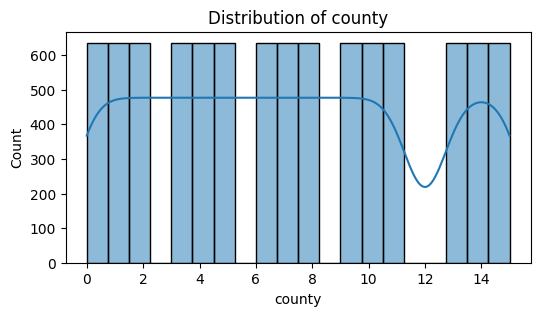

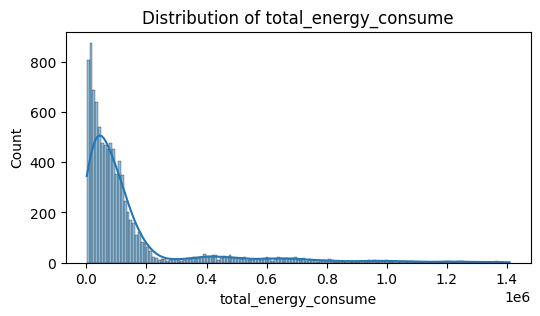

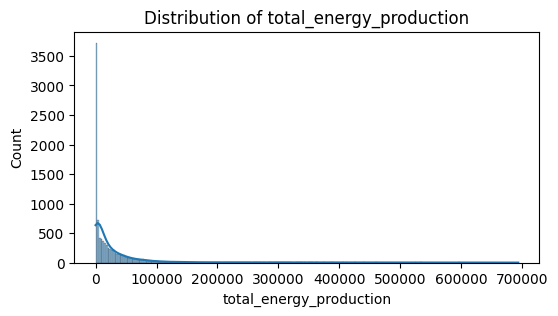

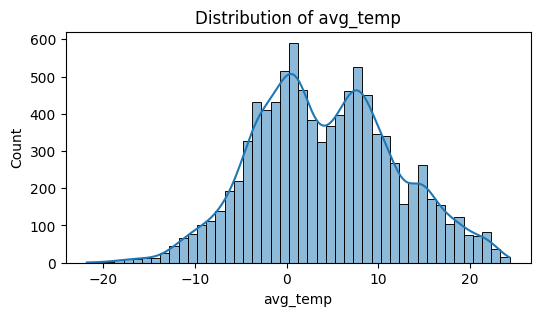

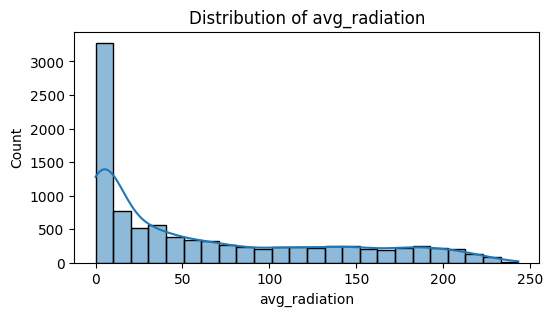

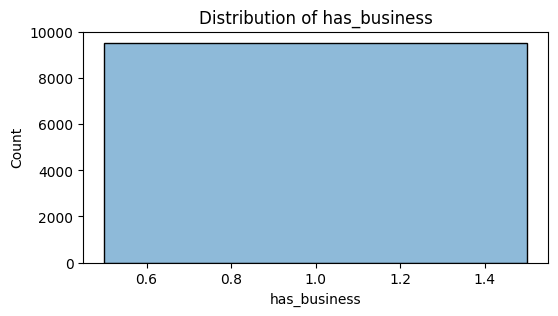

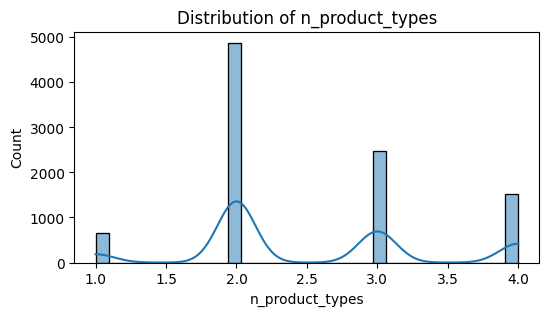

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#fix format of date
panda_df['date'] = pd.to_datetime(panda_df['date'], errors='coerce')

num_cols = panda_df.select_dtypes(include=['float64', 'int64', 'int32']).columns
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(panda_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

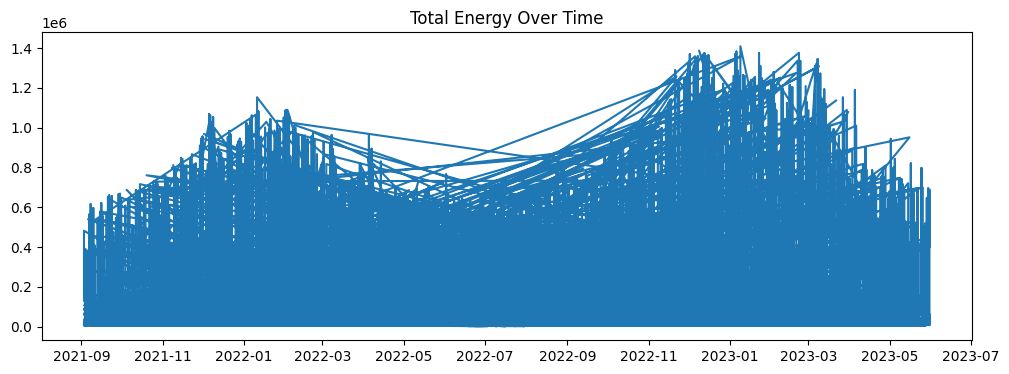

In [0]:
plt.figure(figsize=(12,4))
plt.plot(panda_df['date'],panda_df['total_energy_consume'])
plt.title("Total Energy Over Time")
plt.show()

Look at the relationship between total_energy_comsume with county vs avg_temp

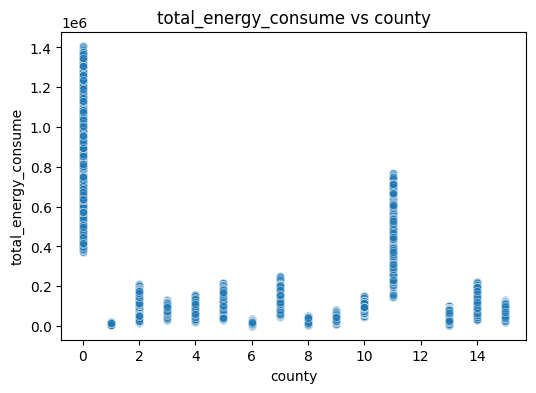

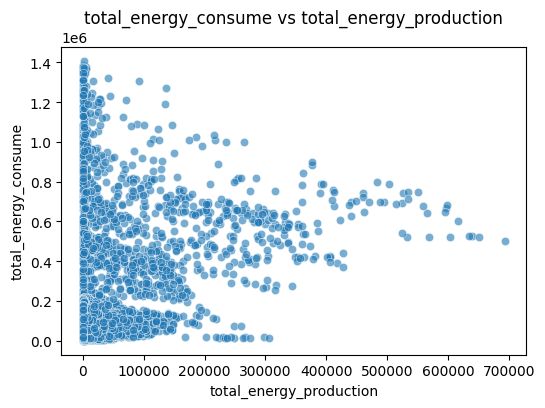

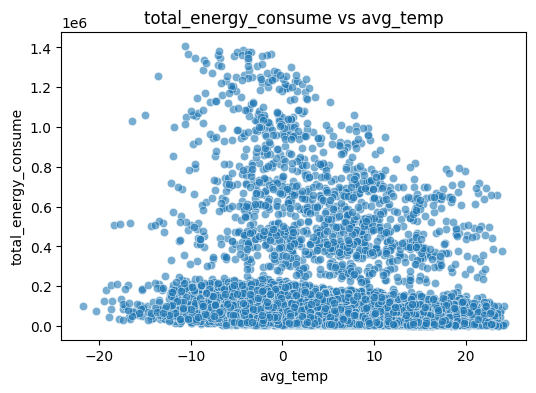

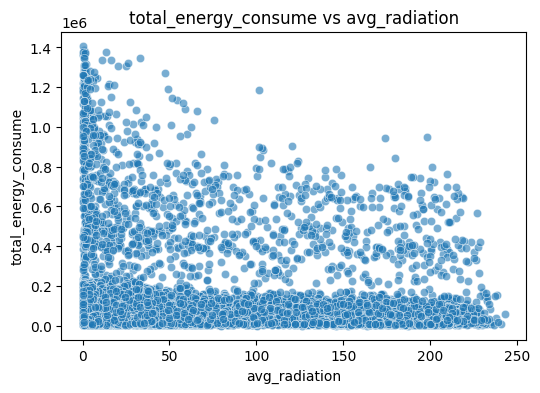

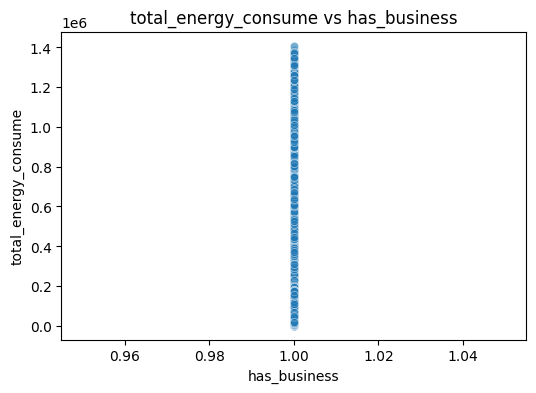

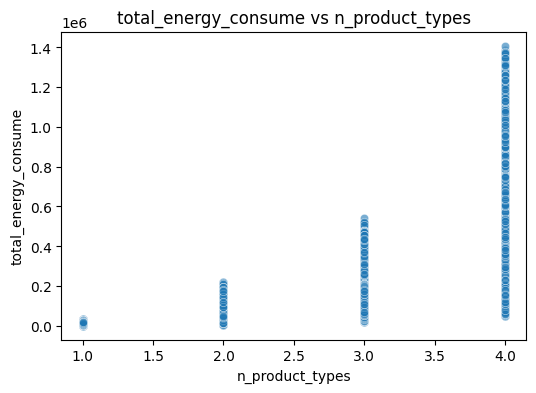

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = panda_df.select_dtypes(include='number').columns
num_cols = num_cols.drop('total_energy_consume', errors='ignore')

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=panda_df, x=col, y='total_energy_consume', alpha=0.6)
    plt.title(f"total_energy_consume vs {col}")
    plt.xlabel(col)
    plt.ylabel("total_energy_consume")
    plt.show()

Boxplots for all the outliers in data

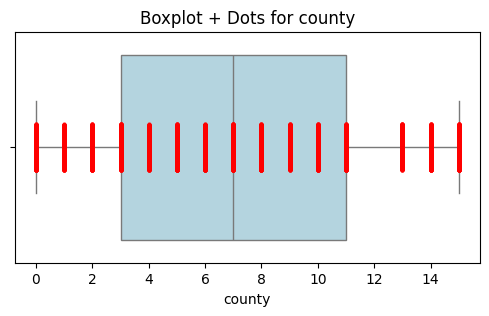

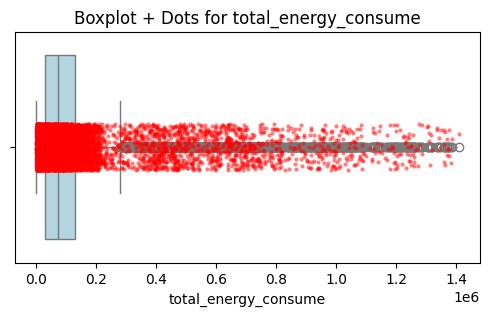

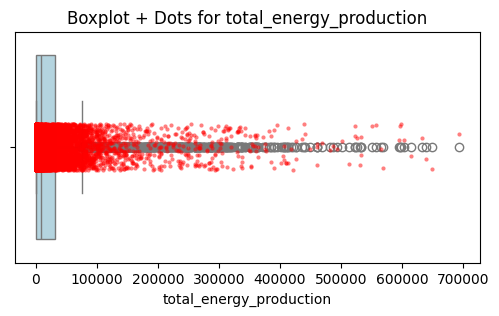

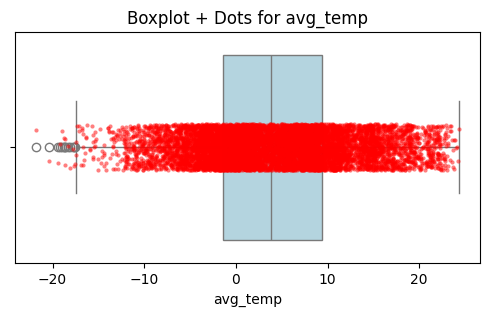

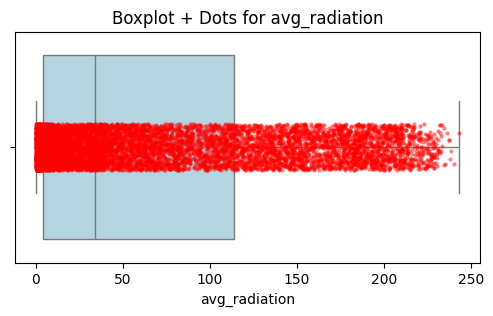

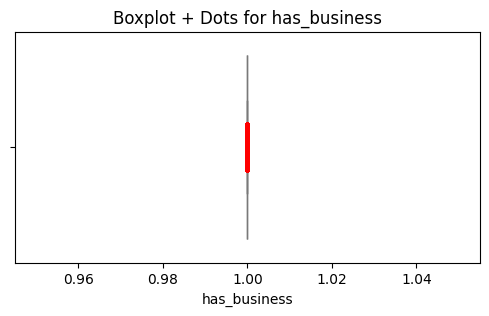

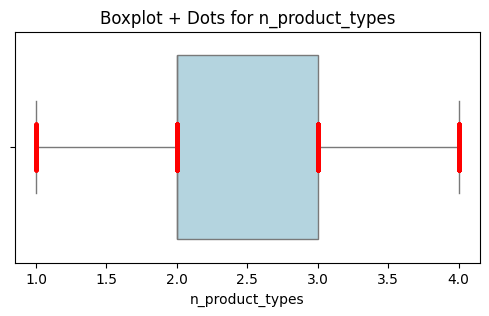

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = panda_df.select_dtypes(include=['float64', 'int64', 'int32']).columns

for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=panda_df[col], color="lightblue")
    sns.stripplot(x=panda_df[col], color="red", size=3, alpha=0.5)  # dots for all values
    plt.title(f"Boxplot + Dots for {col}")
    plt.show()

Make a correlation matrix

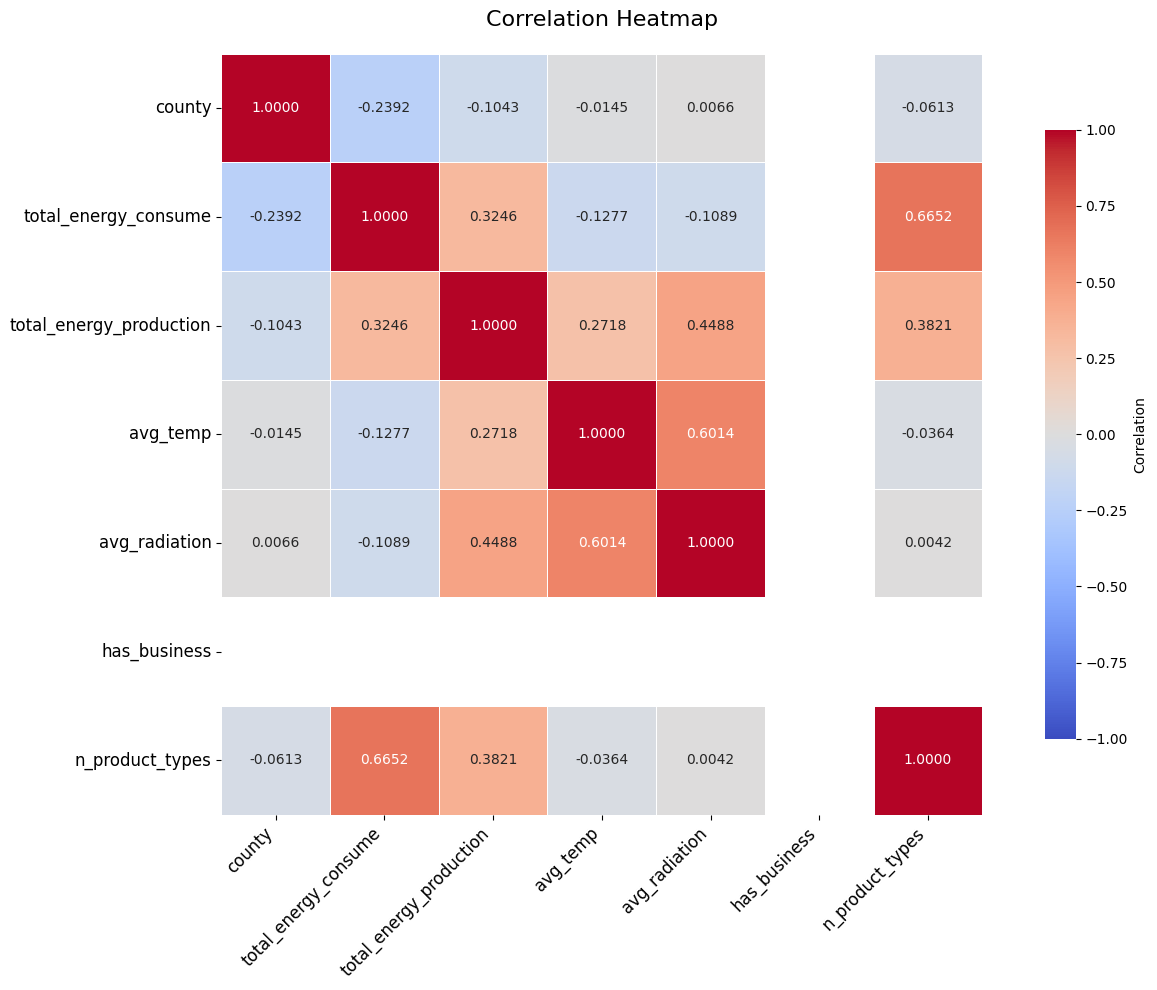

In [0]:
#correlation matrix 
plt.figure(figsize=(14,10))
corr = panda_df[num_cols].corr()

sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,            
    fmt=".4f",             
    vmin=-1, vmax=1,   
    center=0,              # center colormap at 0
    square=True,           
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)

plt.title("Correlation Heatmap", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Correlation matrix shows that many things are correlated and there is multicollinearity. For example temp and radiation. 

Y variable is total_energy_consume.Along with that, avg radiation and total energy production are all very right skewed. Need to log transform all. Instead of transforming, i will add additional log transformed columns.

In [0]:
#add log transformations to right skewed variables 
import numpy as np

logged = panda_df.copy()
logged.loc[:, 'total_energy_consume_log'] = np.log1p(logged['total_energy_consume'])
logged.loc[:, 'avg_radiation_log'] = np.log1p(logged['avg_radiation'])
logged.loc[:, 'total_energy_production_log'] = np.log1p(logged['total_energy_production'])

#show dataset
logged.head()



date  county  ...  avg_radiation_log  total_energy_production_log
0 2022-10-28       8  ...           2.484907                     6.604157
1 2022-10-28       4  ...           2.374044                     6.554653
2 2022-10-28       0  ...           2.233592                     8.615387
3 2022-10-28       3  ...           2.245427                     6.190178
4 2022-10-28      14  ...           2.411273                     7.352740

[5 rows x 11 columns]

look for feature-target relationship

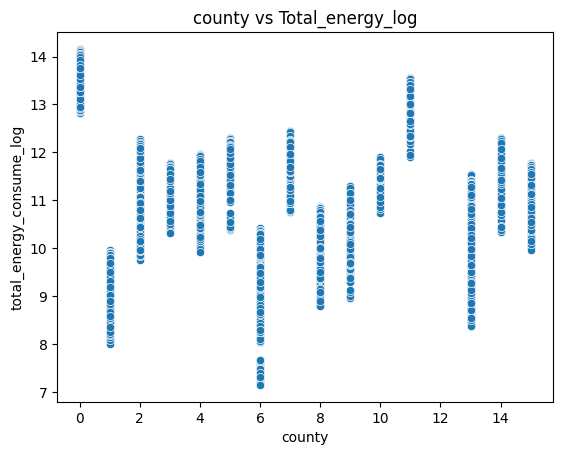

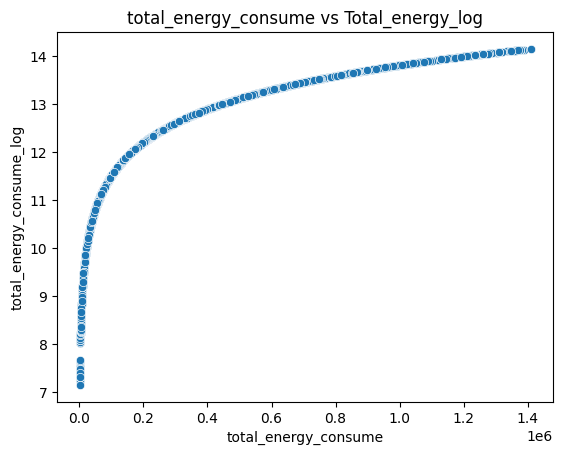

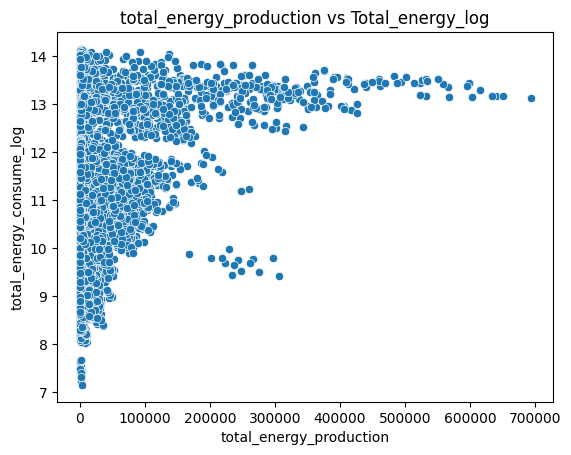

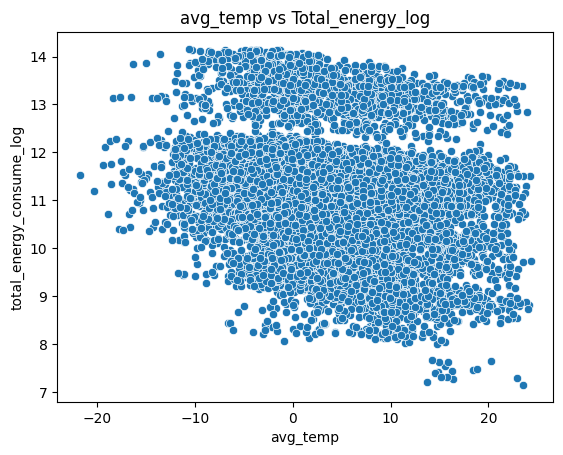

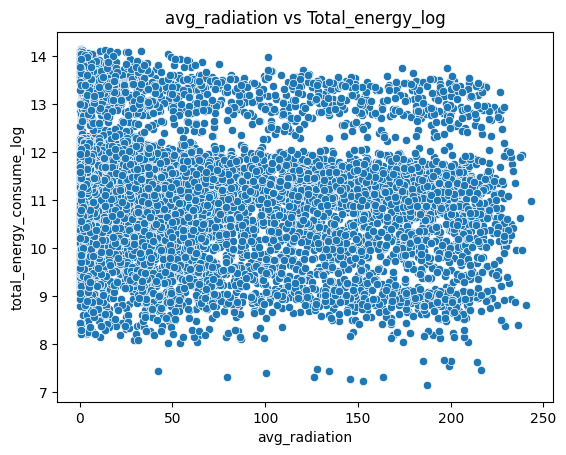

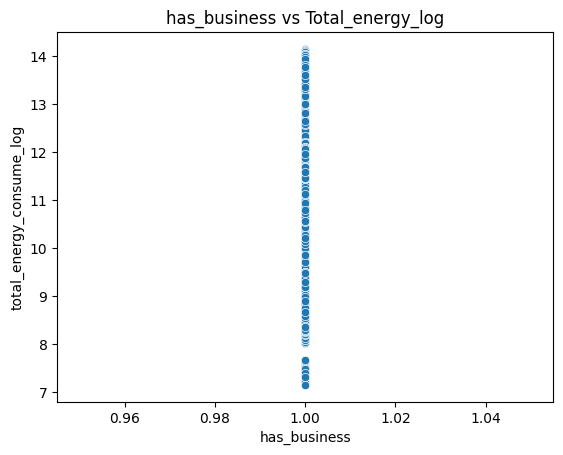

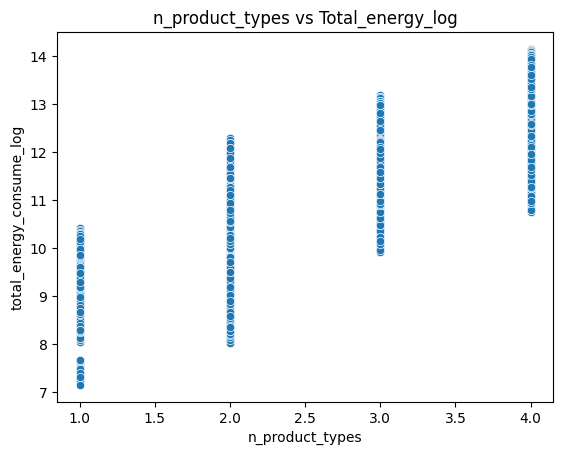

In [0]:
for col in num_cols:
    if col != 'total_energy_consume_log':
        sns.scatterplot(data=logged, x=col, y='total_energy_consume_log')
        plt.title(f"{col} vs Total_energy_log")
        plt.show()

#Build Model

In [0]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import mlflow
import mlflow.spark

In [0]:
#need to split date and time

logged["date"] = pd.to_datetime(logged["date"])

# date features
logged["year"] = logged["date"].dt.year
logged["month"] = logged["date"].dt.month
logged["dayofweek"] = logged["date"].dt.dayofweek   # 0=Mon, 6=Sun


In [0]:
logged.head()

date  county  total_energy_consume  ...  year  month  dayofweek
0 2022-10-28       8             34667.718  ...  2022     10          4
1 2022-10-28       4            123841.008  ...  2022     10          4
2 2022-10-28       0            918373.947  ...  2022     10          4
3 2022-10-28       3             89949.189  ...  2022     10          4
4 2022-10-28      14            175474.854  ...  2022     10          4

[5 rows x 14 columns]

In [0]:
#save this table as delta. it's production ready 
spark_logged = spark.createDataFrame(logged)
spark_logged.write \
    .format("delta") \
    .mode("overwrite") \
    .saveAsTable("cscie103_catalog_final.gold.logged_features")

Split data into train and test

In [0]:
df = spark.read.table("cscie103_catalog_final.gold.logged_features")

trainDF2, testDF2 = df.randomSplit([0.8, 0.2], seed=12)
print(trainDF2.count(), testDF2.count())

7655 1885


use xgboost

In [0]:
FEATURES2 = [
    "avg_temp",
    "avg_radiation",
    "has_business",
    "n_product_types",
    "total_energy_production_log",
    "year",
    "month",
    "dayofweek"
]
LABEL2 = "total_energy_consume_log"

county is an integer ID, need to clarify this is a category and not a numerical value

In [0]:
FEATURES2 = [
    "avg_temp",
    "avg_radiation",
    "has_business",
    "n_product_types",
    "total_energy_production_log",
    "year",
    "month",
    "dayofweek"
]
LABEL2 = "total_energy_consume_log"

# nclude county so you can create county_enc (but don't use county as a model feature)
cols_to_pull = FEATURES2 + ["county"] + [LABEL2]

train_pd2 = trainDF2.select(*cols_to_pull).dropna().toPandas()
test_pd2  = testDF2.select(*cols_to_pull).dropna().toPandas()

# target encoding fit on TRAIN only
county_mean = train_pd2.groupby("county")[LABEL2].mean()
global_mean = train_pd2[LABEL2].mean()

train_pd2["county_enc"] = train_pd2["county"].map(county_mean).fillna(global_mean)
test_pd2["county_enc"]  = test_pd2["county"].map(county_mean).fillna(global_mean)

# add encoded county to features, drop raw county
FEATURES2 = FEATURES2 + ["county_enc"]

X_train2 = train_pd2[FEATURES2]
y_train2 = train_pd2[LABEL2]

X_test2  = test_pd2[FEATURES2]
y_test2  = test_pd2[LABEL2]


In [0]:
print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)
print(X_train2.columns)

(7655, 9) (7655,)
(1885, 9) (1885,)
Index(['avg_temp', 'avg_radiation', 'has_business', 'n_product_types',
       'total_energy_production_log', 'year', 'month', 'dayofweek',
       'county_enc'],
      dtype='object')


County is fixed.

In [0]:
import mlflow
import mlflow.xgboost
import numpy as np
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mlflow.set_experiment("/Workspace/Users/seo549@g.harvard.edu/energy_xgboost2")
mlflow.xgboost.autolog(log_models=True)

with mlflow.start_run(run_name="xgb_regressor_v2"):
    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    # train
    model.fit(X_train2, y_train2)

    # predict
    pred_log = model.predict(X_test2)

    # metrics in log space 
    rmse_log = np.sqrt(mean_squared_error(y_test2, pred_log))
    mae_log  = mean_absolute_error(y_test2, pred_log)
    r2_log   = r2_score(y_test2, pred_log)

    mlflow.log_metric("rmse_log_test", rmse_log)
    mlflow.log_metric("mae_log_test", mae_log)
    mlflow.log_metric("r2_log_test", r2_log)

    print({"rmse_log_test": rmse_log, "mae_log_test": mae_log, "r2_log_test": r2_log})

    #  log original-units metrics 
    pred = np.expm1(pred_log)
    actual = np.expm1(y_test2)

    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae  = mean_absolute_error(actual, pred)
    mape = np.mean(np.abs(pred - actual) / np.maximum(actual, 1e-9)) * 100

    mlflow.log_metric("rmse_test", rmse)
    mlflow.log_metric("mae_test", mae)
    mlflow.log_metric("mape_test", mape)

    run_id = mlflow.active_run().info.run_id
    model_uri = f"runs:/{run_id}/model"

    print("run_id:", run_id)
    print("model_uri:", model_uri)

2025/12/12 21:27:41 INFO mlflow.tracking.fluent: Experiment with name '/Workspace/Users/seo549@g.harvard.edu/energy_xgboost2' does not exist. Creating a new experiment.
2025/12/12 21:27:41 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.1.2. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.


{'rmse_log_test': np.float64(0.14555206859747313), 'mae_log_test': 0.09723301550345761, 'r2_log_test': 0.9863574496094758}
run_id: f05a63929963416690750d8591b8738a
model_uri: runs:/f05a63929963416690750d8591b8738a/model


In [0]:
out_pd = test_pd2.copy()

out_pd["pred_log_total_energy"] = pred_log

# inverse for log1p
out_pd["pred_total_energy"] = np.expm1(out_pd["pred_log_total_energy"])
out_pd["actual_total_energy"] = np.expm1(out_pd[LABEL2])  

out_pd["abs_err"] = np.abs(out_pd["pred_total_energy"] - out_pd["actual_total_energy"])
out_pd["pct_err"] = out_pd["abs_err"] / np.maximum(out_pd["actual_total_energy"], 1e-9)

(spark.createDataFrame(out_pd)
  .write
  .mode("overwrite")
  .format("delta")
  .saveAsTable("cscie103_catalog_final.gold.final_predictions"))

In [0]:
#Table to show actual and prediction values 

display(spark.table("cscie103_catalog_final.gold.final_predictions"))

avg_temp avg_radiation has_business n_product_types total_energy_production_log year month dayofweek county total_energy_consume_log county_enc pred_log_total_energy pred_total_energy actual_total_energy abs_err pct_err 9.738888888888887 115.20370370370372 1 3 9.591989996037572 2021 9 4 4 10.981717798079123 11.289562441388032 10.944379 56633.797 58788.456000000006 2154.6591250000056 0.036651058245176664 12.099999999999998 93.63888888888889 1 3 10.276087089396906 2021 9 4 10 11.40804617794777 11.45960845709067 11.380734 87616.36 90042.32100000003 2425.9616250000254 0.026942459923928713 9.53888888888889 107.52777777777777 1 2 9.671153018241165 2021 9 4 13 11.089085437305988 10.337055378492034 10.604509 40315.227 65451.858 25136.6314375 0.38404763753994575 9.484259259259257 118.68518518518519 1 2 10.255378908338917 2021 9 4 14 11.574515879082636 11.700210846679491 11.649118 114589.3 106351.66500000002 8237.631874999977 0.07745653887976249 14.24583333333333 65.35416666666667 1 3 8.08027797266982 2021 9 6 5 11.81616749347975 11.755990307791697 11.667962 116769.07 135423.21900000007 18654.14868750007 0.1377470482923616 13.884722222222214 82.39583333333333 1 3 8.730079031840877 2021 9 6 10 11.136962162333692 11.45960845709067 10.963896 57749.992 68661.75299999997 10911.760812499968 0.15892051012009514 14.313333333333333 111.3055555555555 1 2 9.234582053644193 2021 9 6 15 10.223913083832882 10.99762399717315 10.182308 26430.406 27553.278000000006 1122.8717500000057 0.04075274637014171 7.420833333333338 82.84722222222221 1 1 8.427347255402761 2021 9 5 2 9.958505048468172 10.843083676859772 9.72696 16762.518 21130.181999999983 4367.6644218749825 0.20670264088946258 8.425000000000002 83.90277777777779 1 1 6.741700694652055 2021 9 5 6 8.2863777865469 9.273440504008539 8.407053 4477.543 3968.43 509.11296875000016 0.12829077714612586 7.41777777777778 67.81666666666669 1 2 10.358094032974188 2021 9 5 15 10.134272354988116 10.99762399717315 10.203793 27004.412 25190.763000000014 1813.6491093749864 0.07199659293269463 5.280555555555558 16.02777777777778 1 2 8.479548228116803 2021 9 2 8 9.721431240561657 10.07458295412484 9.752229 17191.504 16670.088000000014 521.4159062499857 0.03127853351763862 5.238888888888888 20.09722222222222 1 3 10.552793288788608 2021 9 2 11 12.876585509192564 12.914776983155333 12.849187 380478.25 391046.9670000001 10568.71700000012 0.02702672029674665 5.08888888888889 16.22222222222222 1 2 8.803255803249264 2021 9 2 13 11.25283868905569 10.337055378492034 10.844292 51239.816 77097.46799999996 25857.651593749964 0.33538911542140365 6.645370370370366 45.77777777777778 1 2 7.572000286672279 2021 9 4 9 10.166923588605037 10.360127442240328 10.254816 28418.08 26026.880999999987 2391.1990781250133 0.09187420798231699 11.363888888888892 47.30555555555556 1 1 4.743992556669193 2021 10 3 6 9.296872225679563 9.273440504008539 9.317807 11133.539 10902.860999999995 230.67806250000467 0.02115757162271488 9.061111111111112 62.19444444444447 1 2 9.655814408155642 2021 10 3 13 11.12528140447836 10.337055378492034 10.720275 45263.344 67864.38599999997 22601.04224999997 0.3330324428191243 8.55333333333333 65.05555555555556 1 2 10.091060090433055 2021 10 3 15 10.553193164652747 10.99762399717315 10.573326 39077.438 38298.539999999986 778.8975000000137 0.02033752461582123 7.613888888888887 36.53472222222222 1 2 7.261182253975735 2021 10 5 2 10.176023867372685 10.843083676859772 10.256873 28476.602 26264.822999999982 2211.778562500018 0.0842106783853072 7.816666666666665 49.50555555555557 1 4 9.510241462239874 2021 10 5 7 11.204981676657237 11.706802881687539 11.228015 75207.16 73494.663 1712.4932499999995 0.02330091982325301 4.325000000000001 58.80555555555556 1 2 7.990214133940606 2021 10 5 13 10.674961947074443 10.337055378492034 10.664999 42829.21 43258.05900000001 428.8480625000084 0.009913714864090603 1.6018518518518523 36.14814814814814 1 3 5.171296165138711 2021 10 2 4 11.314103738000728 11.289562441388032 11.278952 79137.25 81968

Actual vs Predicted

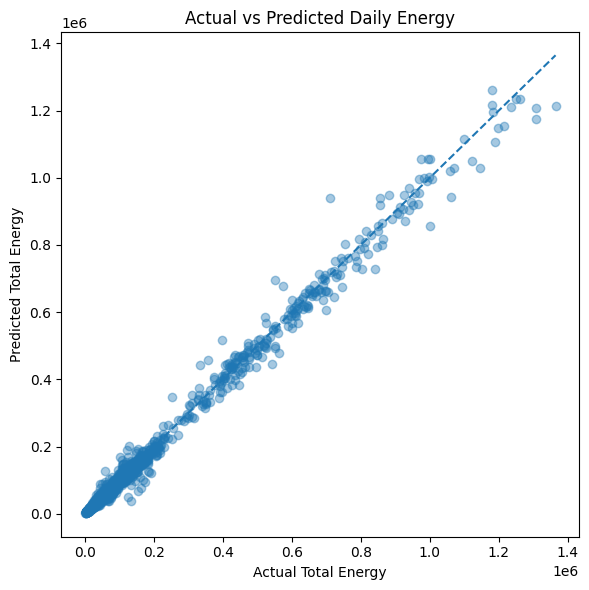

In [0]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,6))
plt.scatter(
    out_pd["actual_total_energy"],
    out_pd["pred_total_energy"],
    alpha=0.4
)

max_val = max(
    out_pd["actual_total_energy"].max(),
    out_pd["pred_total_energy"].max()
)

plt.plot([0, max_val], [0, max_val], linestyle="--")  # perfect-fit line
plt.xlabel("Actual Total Energy")
plt.ylabel("Predicted Total Energy")
plt.title("Actual vs Predicted Daily Energy")
plt.tight_layout()
plt.show()

Residual Plot

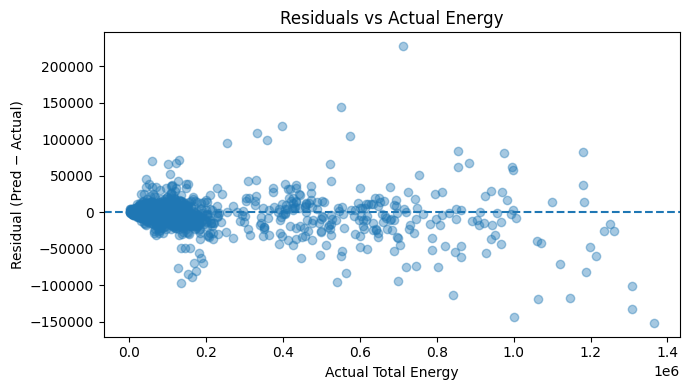

In [0]:
out_pd["residual"] = out_pd["pred_total_energy"] - out_pd["actual_total_energy"]

plt.figure(figsize=(7,4))
plt.scatter(
    out_pd["actual_total_energy"],
    out_pd["residual"],
    alpha=0.4
)
plt.axhline(0, linestyle="--")
plt.xlabel("Actual Total Energy")
plt.ylabel("Residual (Pred − Actual)")
plt.title("Residuals vs Actual Energy")
plt.tight_layout()
plt.show()

error distribution

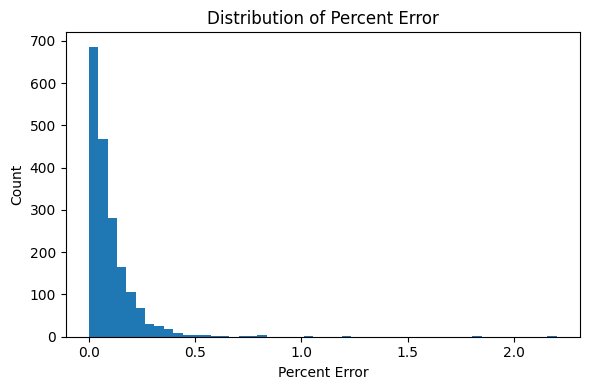

In [0]:
plt.figure(figsize=(6,4))
plt.hist(out_pd["pct_err"], bins=50)
plt.xlabel("Percent Error")
plt.ylabel("Count")
plt.title("Distribution of Percent Error")
plt.tight_layout()
plt.show()

metrics table

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

metrics = {
    "MAE_log": mean_absolute_error(y_test2, pred_log),
    "RMSE_log": np.sqrt(mean_squared_error(y_test2, pred_log)),
    "R2_log": r2_score(y_test2, pred_log),
    "MAE": mean_absolute_error(out_pd["actual_total_energy"], out_pd["pred_total_energy"]),
    "RMSE": np.sqrt(mean_squared_error(out_pd["actual_total_energy"], out_pd["pred_total_energy"])),
    "MAPE_%": np.mean(out_pd["pct_err"]) * 100
}

metrics_df = (
    spark.createDataFrame(
        [(k, float(v)) for k,v in metrics.items()],
        ["metric", "value"]
    )
)

display(metrics_df)

metric value MAE_log 0.09723301550345761 RMSE_log 0.14555206859747313 R2_log 0.9863574496094758 MAE 9638.462477599674 RMSE 19043.365698977428 MAPE_% 9.849041804500796

Which features matter the most?

In [0]:
import pandas as pd

importance = model.get_booster().get_score(importance_type="gain")

imp_df = (
    pd.DataFrame({
        "feature": importance.keys(),
        "gain": importance.values()
    })
    .sort_values("gain", ascending=False)
)

imp_df

feature       gain
7                   county_enc  16.483137
2              n_product_types   9.594130
4                         year   1.032624
6                    dayofweek   0.682672
5                        month   0.634705
0                     avg_temp   0.525710
3  total_energy_production_log   0.511178
1                avg_radiation   0.348388